<a href="https://colab.research.google.com/github/Saadman53/Thesis-Human-Activity-Recognition/blob/Defense/Intermediate%20Feature%20Level%20Fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ax-platform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 KB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.8/245.8 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.0 MB/s eta 0:00:00


In [3]:
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
from statsmodels.multivariate.cancorr import CanCorr

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data

from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import torch.optim as optim
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render
from ax.utils.tutorials.cnn_utils import train, evaluate


import torchvision
import torchvision.transforms as transforms



import random
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report


from torch.utils.data import DataLoader, ConcatDataset
# from torchvision import transforms
from sklearn.model_selection  import StratifiedKFold

import torch.optim.lr_scheduler as lr_scheduler
%matplotlib inline

import scipy.io as sio
torch.autograd.set_detect_anomaly(True)


from functools import partial
from typing import Any, Optional

import torch
import torch.nn as nn
#stats_cca = CanCorr(Y_train, X_train)

# print(stats_cca.corr_test().summary())
# X_train_c = stats_cca.x_cancoef
# Y_train_c = stats_cca.y_cancoef

In [13]:
gdrive_path = "drive/My Drive/Dataset/Final Dataset/Train Test Set/alexnet_DMM_Sobel_train_test_set.mat"
acc_path = "drive/My Drive/Dataset/Final Dataset/Train Test Set/acc_train_test_val.mat"
gyro_path = "drive/My Drive/Dataset/Final Dataset/Train Test Set/gyro_train_test_val.mat"

In [14]:
dat1 = sio.loadmat(gdrive_path)
dat2 = sio.loadmat(acc_path)
dat3 = sio.loadmat(gyro_path)

In [16]:
X_train1 = dat1['X_train']
X_test1 = dat1['X_test']
X_val1 = dat1['X_val']
X_train2 = dat2['X_train']
X_test2 = dat2['X_test']
X_val2 = dat2['X_val']
X_train3 = dat3['X_train']
X_test3 = dat3['X_test']
X_val3 = dat3['X_val']

y_train = dat1['y_train'].ravel()
y_test = dat1['y_test'].ravel()
y_val = dat1['y_val'].ravel()

In [17]:
print(X_train2.shape, X_train3.shape)

(742, 222) (742, 91)


In [18]:
X_train2 = np.concatenate((X_train2,X_train3),axis = 1)
X_test2 = np.concatenate((X_test2,X_test3),axis = 1)
X_val2 = np.concatenate((X_val2,X_val3),axis = 1)

In [20]:
print(X_train1.shape, X_train2.shape)

(742, 4096) (742, 313)


In [23]:
import pickle


In [24]:
def dim_red(X_train, X_test,X_val,n_components):
  pca = PCA(n_components)
  X_train = pca.fit_transform(X_train)
  X_test = pca.transform(X_test)
  X_val = pca.transform(X_val)
  return X_train, X_test,X_val,pca


def CCAFusion(train_X, train_Y, test_X, test_Y, val_X, val_Y):
    n,p = train_X.shape
    q   = train_Y.shape[1]
    n_components = min(n,p,q)
    
    sc1 = StandardScaler()
    train_X = sc1.fit_transform(train_X)
    test_X = sc1.transform(test_X)
    val_X = sc1.transform(val_X)
    
    sc2 = StandardScaler()
    train_Y = sc2.fit_transform(train_Y)
    test_Y = sc2.transform(test_Y)
    val_Y = sc2.transform(val_Y)
    
    train_X, test_X, val_X,pca = dim_red(train_X, test_X, val_X, n_components)
    
    ca = CCA(n_components)
    ca.fit(train_X, train_Y)
    train_X, train_Y = ca.transform(train_X, train_Y)
    test_X, test_Y = ca.transform(test_X, test_Y)
    val_X, val_Y = ca.transform(val_X, val_Y)
    pickle.dump(pca, open("drive/My Drive/Dataset/Final Dataset/Models/PCA/SOBEL_PCA.pkl",'wb'))
    pickle.dump(ca, open("drive/My Drive/Dataset/Final Dataset/Models/CCA/concat(acc,gyro)_sobel_CCA.pkl",'wb'))
    return np.concatenate((train_X,train_Y), axis= 1), np.concatenate((test_X,test_Y), axis= 1), np.concatenate((val_X,val_Y), axis= 1),train_X+train_Y,test_X+test_Y,val_X+val_Y

In [25]:
start = time.time()
X_train_c,X_test_c,X_val_c, X_train_s,X_test_s,X_val_s = CCAFusion(X_train1, X_train2, X_test1, X_test2, X_val1, X_val2)
end = time.time()
print(f"It took {end-start} seconds to CCA Fuse.")

It took 123.05213618278503 seconds to CCA Fuse.


In [26]:
print(X_train_c.shape,X_test_c.shape,X_val_c.shape,X_train_s.shape,X_test_s.shape,X_val_s.shape)

(742, 626) (291, 626) (131, 626) (742, 313) (291, 313) (131, 313)


In [28]:
scaler = StandardScaler()
train_X = scaler.fit_transform(X_train_c)
pickle.dump(scaler, open("drive/My Drive/Dataset/Final Dataset/Models/Standard Scaler/concat(acc,gyro)_sobel_Scaler.pkl",'wb'))
train_X.shape

(742, 626)

In [29]:
def train_test_loader(X_train, X_test, y_train, y_test):
  scaler = StandardScaler()
  train_X = X_train.copy()
  test_X = X_test.copy()
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)
  train_dataset = TensorDataset(Tensor(train_X), Tensor(y_train))
  test_dataset = TensorDataset(Tensor(test_X), Tensor(y_test))
  test_loader = DataLoader(test_dataset, batch_size= 64)
  return train_dataset, test_loader

In [30]:
class DNN(nn.Module):
    def __init__(self,input_size,output_size):
        super(DNN,self).__init__()
        self.hidden1 = nn.Linear(input_size,256)
        self.hidden2 = nn.Linear(256,128)
        self.hidden3 = nn.Linear(128,64)
        self.output = nn.Linear(64,output_size)
        self.softmax = F.softmax
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
    
    def forward(self,x):
        out = self.hidden1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        
        out = self.hidden2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.hidden3(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.output(out)
        return out

In [31]:
def net_train(net, train_loader, parameters):
  criterion = nn.CrossEntropyLoss(reduction = "sum")
  optimizer = optim.SGD(net.parameters(), # or any optimizer you prefer 
                        lr=parameters.get("lr", 0.001), # 0.001 is used if no lr is specified
                        momentum=parameters.get("momentum", 0.9)
  )

  scheduler = optim.lr_scheduler.StepLR(
      optimizer,
      step_size=int(parameters.get("step_size", 30)),
      gamma=1.0,  # default is no learning rate decay
  )

  num_epochs = parameters.get("max_epoch", 3) # Play around with epoch number
  # Train Network
  for _ in range(num_epochs):
    for inputs, labels in train_loader:
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels.long())
      loss.backward()
      optimizer.step()
      scheduler.step()
  return net

In [32]:
def train_evaluate(parameterization):
    # constructing a new training data loader allows us to tune the batch size
    train_loader = torch.utils.data.DataLoader(train_set,
                                batch_size=parameterization.get("batchsize", 32),
                                shuffle=True,
                                num_workers=0,
                                pin_memory=True,drop_last=True)
    
    # Get neural net
    untrained_net = DNN(inpsize,outsize)
    # train
    trained_net = net_train(net=untrained_net, train_loader=train_loader, 
                            parameters=parameterization)
    # return the accuracy of the model as it was trained in this run
    return evaluate(
        net=trained_net,
        data_loader=test_loader,
        dtype = torch.float,
        device = "cpu"
    )

In [33]:
train_set, test_loader = train_test_loader(X_train_c, X_val_c, y_train, y_val)
inpsize = X_train_c.shape[1]
outsize = np.unique(y_train).shape[0]
dtype = torch.float
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.2], "log_scale": True},
        {"name": "batchsize", "type": "range", "bounds": [20, 100]},
        {"name": "momentum", "type": "range", "bounds": [0.0, 1.0]},    
        {"name": "max_epoch", "type": "range", "bounds": [10, 100]},
        {"name": "stepsize", "type": "range", "bounds": [20, 40]},     
    ],
  
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)

print(best_parameters)
means, covariances = values
print(means)
print(covariances)

[INFO 02-11 11:10:21] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-11 11:10:21] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batchsize. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-11 11:10:21] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter momentum. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-11 11:10:21] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter max_epoch. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter di

{'lr': 0.0009679948867522709, 'batchsize': 57, 'momentum': 0.8651423503559073, 'max_epoch': 52, 'stepsize': 36}
{'accuracy': 0.9618320610687023}
{'accuracy': {'accuracy': nan}}


In [34]:
best_parameters

{'lr': 0.0009679948867522709,
 'batchsize': 57,
 'momentum': 0.8651423503559073,
 'max_epoch': 52,
 'stepsize': 36}

In [35]:
best_objectives = np.array([[trial.objective_mean*100 for trial in experiment.trials.values()]])

best_objective_plot = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title="Model performance vs. # of iterations",
    ylabel="Classification Accuracy, %",
)
render(best_objective_plot)

render(plot_contour(model=model, param_x='batchsize', param_y='lr', metric_name='accuracy'))

In [36]:
data = experiment.fetch_data()
dff = data.df
best_arm_name = dff.arm_name[dff['mean'] == dff['mean'].max()].values[0]
best_arm = experiment.arms_by_name[best_arm_name]
best_arm

Arm(name='13_0', parameters={'lr': 0.0009679948867522709, 'batchsize': 57, 'momentum': 0.8651423503559073, 'max_epoch': 52, 'stepsize': 36})

In [37]:
def optim_scheduler(net,parameters):
  optimizer = optim.SGD(net.parameters(), # or any optimizer you prefer 
                        lr=parameters.get("lr", 0.001), # 0.001 is used if no lr is specified
                        momentum=parameters.get("momentum", 0.9)
  )
  scheduler = optim.lr_scheduler.StepLR(
      optimizer,
      step_size=int(parameters.get("step_size", 30)),
      gamma=1.0,  # default is no learning rate decay
  )
  return optimizer, scheduler
def extract_batch(X,y,batch_size,step,no_of_samples):
  l = (step-1)*batch_size
  return X[l:(l+batch_size)],y[l:min(no_of_samples,l+batch_size)]

def model_training_evaluation(X_train, X_test, y_train, y_test):
  train_X = X_train
  test_X = X_test
  scaler = StandardScaler()
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)
  train_X = torch.from_numpy(train_X.astype(np.float32))
  test_X = torch.from_numpy(test_X.astype(np.float32))
  train_y =  torch.tensor(y_train.astype(np.float32))
  test_y =  torch.tensor(y_test.astype(np.float32))
  input_size = train_X.shape[1]
  output_size = torch.unique(train_y).shape[0]
  learning_rate = best_parameters['lr']
  num_epochs = best_parameters['max_epoch']
  n_samples = train_X.shape[0]
  criterion = nn.CrossEntropyLoss(reduction='sum')
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
  net = DNN(input_size, output_size)
  optimizer, scheduler = optim_scheduler(net,best_parameters)
  figure, ax = plt.subplots(5,figsize=(10,10))
  figure.tight_layout(pad=5.0)
  cnt = 1
  best_loss = 100000
  best_model = None
  best_epoch = None
  for train_index, val_index in skf.split(X_train, y_train):
    train_X_fold = train_X[train_index]
    train_y_fold = train_y[train_index]
    val_x_fold = train_X[val_index]
    val_y_fold = train_y[val_index]
    n_samples = train_X_fold.shape[0]
    batch_size = best_parameters['batchsize']
    train_loss = []
    val_loss = []
    print(f"Training for fold {cnt}")
    for epoch in range(num_epochs):
      step = 1
      while(batch_size*step<=n_samples):
        x,y =  extract_batch(train_X_fold,train_y_fold, batch_size, step, n_samples)
        # Forward Propagation
        y_predicted = net(x)
        loss = criterion(y_predicted,  torch.tensor(y, dtype=torch.long))
        # Backward propagation and update
        loss.backward()
        optimizer.step()
        scheduler.step()
        # Performing zero grad before new step
        optimizer.zero_grad()
        step = step+1
      t_loss = criterion( net(train_X_fold),  torch.tensor(train_y_fold, dtype=torch.long)).item()/train_X_fold.shape[0]
      v_loss = criterion( net(val_x_fold),  torch.tensor(val_y_fold, dtype=torch.long)).item()/val_x_fold.shape[0]
      train_loss.append(t_loss) 
      val_loss.append(v_loss)
      if(v_loss<best_loss):
        best_loss = v_loss
        best_model = net
        best_epoch = epoch
      print(epoch*100/num_epochs)
    m = "Fold "+str(cnt)
    ax[cnt-1].title.set_text(m)
    ax[cnt-1].set_ylabel("Total Loss")
    ax[cnt-1].set_xlabel("No of Epochs")
    ax[cnt-1].plot(range(num_epochs),train_loss, label = "train loss")
    ax[cnt-1].plot(range(num_epochs),val_loss, label = "validation loss")
    cnt+=1
  y_pred = best_model(test_X)
  return best_model, y_pred


Training for fold 1
0.0
1.2820512820512822
2.5641025641025643
3.8461538461538463
5.128205128205129
6.410256410256411
7.6923076923076925
8.974358974358974
10.256410256410257
11.538461538461538
12.820512820512821
14.102564102564102
15.384615384615385
16.666666666666668
17.94871794871795
19.23076923076923
20.512820512820515
21.794871794871796
23.076923076923077
24.358974358974358
25.641025641025642
26.923076923076923
28.205128205128204
29.487179487179485
30.76923076923077
32.05128205128205
33.333333333333336
34.61538461538461
35.8974358974359
37.17948717948718
38.46153846153846
39.743589743589745
41.02564102564103
42.30769230769231
43.58974358974359
44.87179487179487
46.15384615384615
47.43589743589744
48.717948717948715
50.0
51.282051282051285
52.56410256410256
53.84615384615385
55.12820512820513
56.41025641025641
57.69230769230769
58.97435897435897
60.256410256410255
61.53846153846154
62.82051282051282
64.1025641025641
65.38461538461539
66.66666666666667
67.94871794871794
69.23076923076

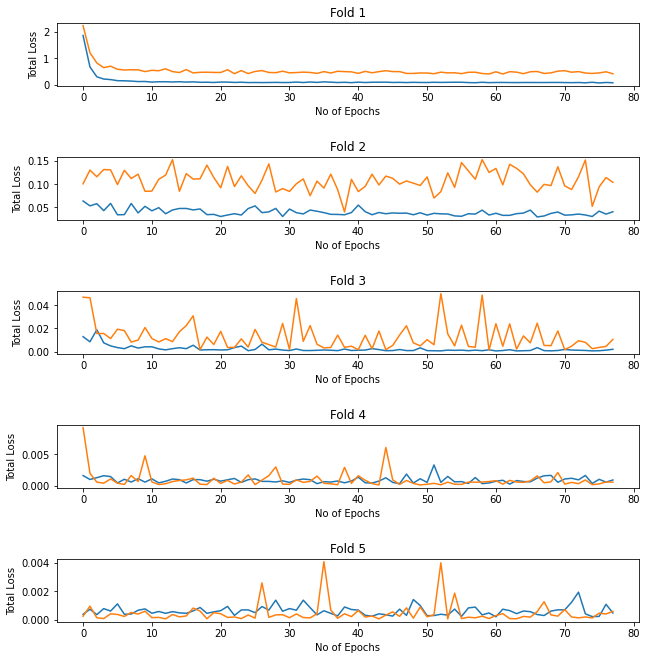

In [52]:
start = time.time()
best_model, y_pred = model_training_evaluation(X_train_c, X_test_c, y_train, y_test)
end = time.time()
training_time = end - start

In [53]:
print(f"Time took to train {training_time} seconds")

Time took to train 60.45803380012512 seconds


In [40]:
def cf_matrix(y_pred, test_y):
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred = torch.max(y_pred_softmax, dim = 1)
  y_pred = y_pred.detach().numpy().ravel()
  correct_pred = (y_pred == test_y).astype(np.float)
  acc = correct_pred.sum()*100.0 / y_pred.shape[0]
  cm = confusion_matrix(test_y.ravel(), y_pred)
  recall = np.mean(recall_score(test_y.ravel(), y_pred, average=None))*100.0
  precision = np.mean(precision_score(test_y.ravel(), y_pred, average=None))*100.0
  f1 = 2*((precision*recall*1.0)/(precision+recall))
  f,ax=plt.subplots(figsize=(20,10))
  sns.heatmap(cm,annot=True,fmt='.0f', cmap="Blues")
  print(f"Accuracy: {acc:.2f}%")
  print(f"Precision: {precision:.2f}%")
  print(f"Recall: {recall:.2f}%")
  print(f"F1 score: {f1:.2f}%")
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()
  return cm,acc, recall, precision, f1


Accuracy: 95.88%
Precision: 96.32%
Recall: 95.83%
F1 score: 96.07%


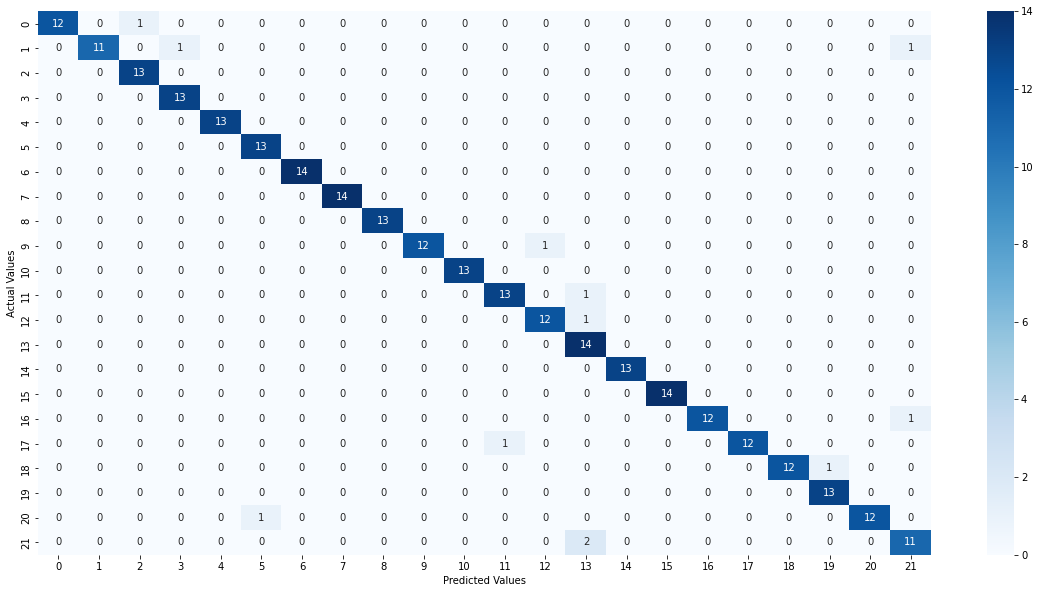

In [54]:
cm,acc, recall, precision,f1 = cf_matrix(y_pred, y_test)

In [55]:
pred_dict = {"preds":y_pred.detach().numpy(), 'y_test':y_test.ravel()}
sio.savemat("drive/My Drive/Dataset/Final Dataset/Predictions/FF_CCA(concat(acc,gyro)+DMM_Sobel, concat)_predictions.mat", pred_dict)

In [56]:
import datetime
ts = str((datetime.datetime.now()).timestamp())
model_save_name = 'Intermediate_FLF_'+ts+'_.pt'
path = F"drive/My Drive/Dataset/Final Dataset/Models/Feature Fusion/{model_save_name}" 
torch.save(best_model.state_dict(), path)

In [44]:
train_set, test_loader = train_test_loader(X_train_s, X_val_s, y_train, y_val)
inpsize = X_train_s.shape[1]
outsize = np.unique(y_train).shape[0]
dtype = torch.float
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.2], "log_scale": True},
        {"name": "batchsize", "type": "range", "bounds": [20, 100]},
        {"name": "momentum", "type": "range", "bounds": [0.0, 1.0]},    
        {"name": "max_epoch", "type": "range", "bounds": [10, 100]},
        {"name": "stepsize", "type": "range", "bounds": [20, 40]},     
    ],
  
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)

print(best_parameters)
means, covariances = values
print(means)
print(covariances)

[INFO 02-11 11:22:48] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-11 11:22:48] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batchsize. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-11 11:22:48] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter momentum. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-11 11:22:48] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter max_epoch. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter di

{'lr': 0.010628821907245819, 'batchsize': 54, 'momentum': 0.0, 'max_epoch': 78, 'stepsize': 33}
{'accuracy': 0.9312977099236641}
{'accuracy': {'accuracy': nan}}


In [45]:
best_parameters

{'lr': 0.010628821907245819,
 'batchsize': 54,
 'momentum': 0.0,
 'max_epoch': 78,
 'stepsize': 33}

In [46]:
best_objectives = np.array([[trial.objective_mean*100 for trial in experiment.trials.values()]])

best_objective_plot = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title="Model performance vs. # of iterations",
    ylabel="Classification Accuracy, %",
)
render(best_objective_plot)

render(plot_contour(model=model, param_x='batchsize', param_y='lr', metric_name='accuracy'))

Training for fold 1
0.0
1.2820512820512822
2.5641025641025643
3.8461538461538463
5.128205128205129
6.410256410256411
7.6923076923076925
8.974358974358974
10.256410256410257
11.538461538461538
12.820512820512821
14.102564102564102
15.384615384615385
16.666666666666668
17.94871794871795
19.23076923076923
20.512820512820515
21.794871794871796
23.076923076923077
24.358974358974358
25.641025641025642
26.923076923076923
28.205128205128204
29.487179487179485
30.76923076923077
32.05128205128205
33.333333333333336
34.61538461538461
35.8974358974359
37.17948717948718
38.46153846153846
39.743589743589745
41.02564102564103
42.30769230769231
43.58974358974359
44.87179487179487
46.15384615384615
47.43589743589744
48.717948717948715
50.0
51.282051282051285
52.56410256410256
53.84615384615385
55.12820512820513
56.41025641025641
57.69230769230769
58.97435897435897
60.256410256410255
61.53846153846154
62.82051282051282
64.1025641025641
65.38461538461539
66.66666666666667
67.94871794871794
69.23076923076

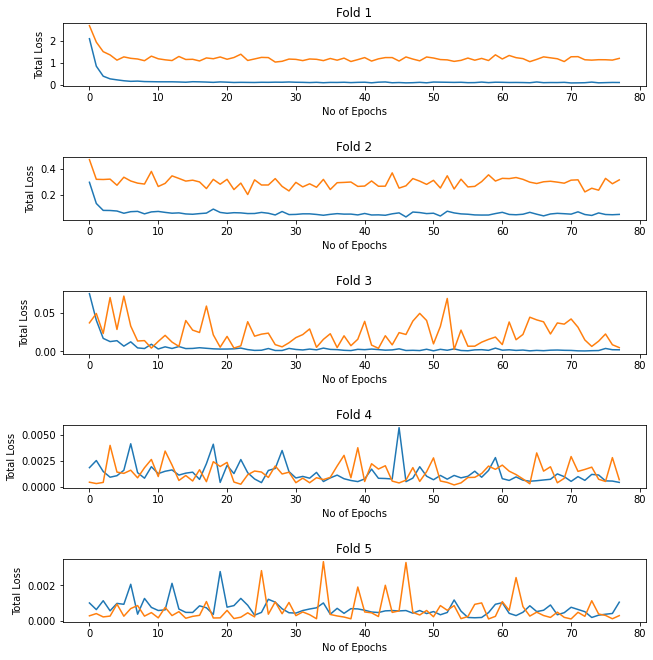

In [50]:
start = time.time()
best_model, y_pred = model_training_evaluation(X_train_s, X_test_s, y_train, y_test)
end = time.time()
training_time = end - start

In [48]:
print(f"Time took to train {training_time} seconds")

Time took to train 62.38476324081421 seconds


Accuracy: 95.88%
Precision: 96.25%
Recall: 95.83%
F1 score: 96.04%


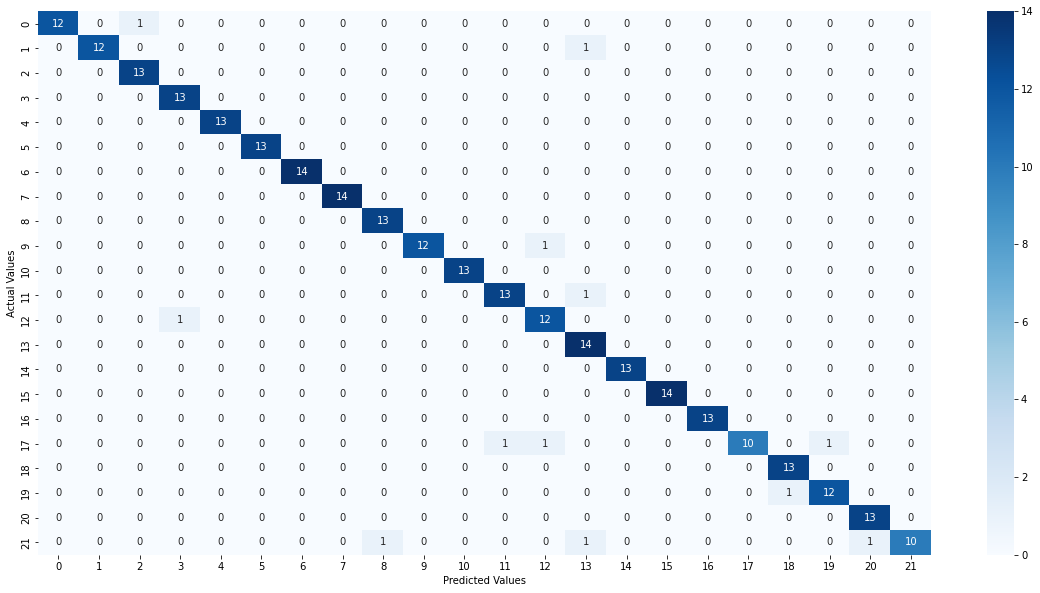

In [49]:
cm,acc, recall, precision,f1 = cf_matrix(y_pred, y_test)

In [51]:
pred_dict = {"preds":y_pred.detach().numpy(), 'y_test':y_test.ravel()}
sio.savemat("drive/My Drive/Dataset/Final Dataset/Predictions/FF_CCA(concat(acc,gyro)+DMM_Sobel, sum)_predictions.mat", pred_dict)

ts = str((datetime.datetime.now()).timestamp())
model_save_name = 'Intermediate_FLF_(sum)'+ts+'_.pt'
path = F"drive/My Drive/Dataset/Final Dataset/Models/Feature Fusion/{model_save_name}" 
torch.save(best_model.state_dict(), path)